### MATH7017 Prababilistic Graphical Models
### ---Final Project---
#### Student Name - Gauri Ratawal
#### Student ID - 22032967

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


#### Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

#### Defining C-VAE Architecture:

In [4]:
# Define the Conditional VAE
class CVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, label_dim, style_dim):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.label_dim = label_dim
        self.style_dim = style_dim

        # Encoder
        self.fc1 = nn.Linear(input_dim + label_dim + style_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc3 = nn.Linear(latent_dim + label_dim + style_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, labels, styles):
        x = torch.cat([x, labels, styles], dim=1)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels, styles):
        z = torch.cat([z, labels, styles], dim=1)
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x, labels, styles):
        mu, logvar = self.encode(x.view(-1, self.input_dim), labels, styles)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, labels, styles), mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

#### Loading and processing data sets for training:

In [5]:
# Load the dataset
train_imgs = np.load('k49-train-imgs.npz')['arr_0']
train_labels = np.load('k49-train-labels.npz')['arr_0']
train_styles = np.load('k49-train-style.npz')['styles']
test_imgs = np.load('k49-test-imgs.npz')['arr_0']
test_labels = np.load('k49-test-labels.npz')['arr_0']
test_styles = np.load('k49-test-style.npz')['styles']

# Normalize images
train_imgs = train_imgs.astype('float32') / 255.
test_imgs = test_imgs.astype('float32') / 255.

# Flatten images
train_imgs = train_imgs.reshape(-1, 784)
test_imgs = test_imgs.reshape(-1, 784)

# Convert to PyTorch tensors
train_imgs = torch.tensor(train_imgs, dtype=torch.float32)
test_imgs = torch.tensor(test_imgs, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)
train_styles = torch.tensor(train_styles, dtype=torch.float32).reshape(-1, 1)
test_styles = torch.tensor(test_styles, dtype=torch.float32).reshape(-1, 1)

# One-hot encode labels
train_labels_one_hot = F.one_hot(train_labels, num_classes=49).float()
test_labels_one_hot = F.one_hot(test_labels, num_classes=49).float()

# Create DataLoader
batch_size = 128
train_dataset = TensorDataset(train_imgs, train_labels_one_hot, train_styles)
test_dataset = TensorDataset(test_imgs, test_labels_one_hot, test_styles)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Initializing and Training C-VAE Model:

In [7]:
# Model instantiation
input_dim = 784  # 28x28 images flattened
hidden_dim = 512
latent_dim = 20
label_dim = 49
style_dim = 1

model = CVAE(input_dim, hidden_dim, latent_dim, label_dim, style_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training and testing functions
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, labels, styles) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels, styles)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Calculate accuracy
        pred = recon_batch.round()
        correct += pred.eq(data.view_as(pred)).sum().item()
        total += data.size(0) * data.size(1)
 
        if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    accuracy = 100. * correct / total
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}, Accuracy: {accuracy:.2f}%')

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels, styles in test_loader:
            recon, mu, logvar = model(data, labels, styles)
            test_loss += loss_function(recon, data, mu, logvar).item()

            # Calculate accuracy
            pred = recon.round()
            correct += pred.eq(data.view_as(pred)).sum().item()
            total += data.size(0) * data.size(1)

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / total
    print(f'====> Test set loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Training loop
epochs = 150
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Streaming output truncated to the last 5000 lines.
Train Epoch: 123 [194560/232365 (84%)]	Loss: 157.086075
Train Epoch: 123 [195840/232365 (84%)]	Loss: 179.338425
Train Epoch: 123 [197120/232365 (85%)]	Loss: 171.140915
Train Epoch: 123 [198400/232365 (85%)]	Loss: 176.190720
Train Epoch: 123 [199680/232365 (86%)]	Loss: 173.300568
Train Epoch: 123 [200960/232365 (86%)]	Loss: 183.700180
Train Epoch: 123 [202240/232365 (87%)]	Loss: 171.659348
Train Epoch: 123 [203520/232365 (88%)]	Loss: 156.350311
Train Epoch: 123 [204800/232365 (88%)]	Loss: 173.683334
Train Epoch: 123 [206080/232365 (89%)]	Loss: 176.326553
Train Epoch: 123 [207360/232365 (89%)]	Loss: 176.865799
Train Epoch: 123 [208640/232365 (90%)]	Loss: 169.273788
Train Epoch: 123 [209920/232365 (90%)]	Loss: 180.783417
Train Epoch: 123 [211200/232365 (91%)]	Loss: 175.411179
Train Epoch: 123 [212480/232365 (91%)]	Loss: 173.140411
Train Epoch: 123 [213760/232365 (92%)]	Loss: 167.293503
Train Epoch: 123 [215040/232365 (93%)]	Loss: 166.0857

#### Visualize Reconstructed Images from Trained C-VAE Model:

In [8]:
# Visualize one reconstructed image from each class
def visualize_reconstructions(model):
    model.eval()
    fig, axes = plt.subplots(7, 7, figsize=(5, 5))  # Match the figsize
    for i in range(49):
        idx = np.where(test_labels == i)[0][0]
        data, labels, styles = test_imgs[idx], test_labels_one_hot[idx], test_styles[idx]
        data, labels, styles = data.unsqueeze(0), labels.unsqueeze(0), styles.unsqueeze(0)
        with torch.no_grad():
            recon, _, _ = model(data, labels, styles)
        ax = axes[i // 7, i % 7]
        ax.imshow(recon.view(28, 28).cpu().numpy(), cmap='gray', interpolation='none')
        ax.axis('on')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)  # Remove internal grids
        for spine in ax.spines.values():
            spine.set_edgecolor('black')  # Add border to the grid

    # Add common x and y axis labels outside the image grid
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.suptitle("Reconstructed Images from Each Class", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


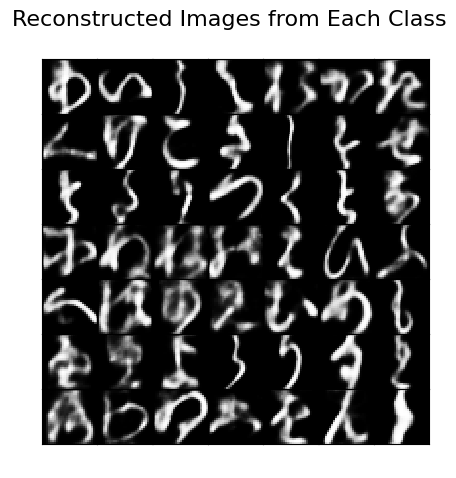

In [9]:
# Visualize reconstructions
visualize_reconstructions(model)

#### Generate Characters using trained C-VAE model:

In [10]:
# Generate new images
def generate_images(model, num_images, label, style):
    model.eval()
    labels_one_hot = F.one_hot(torch.tensor([label] * num_images), num_classes=label_dim).float()
    styles = torch.tensor([style] * num_images).reshape(-1, 1)
    z = torch.randn(num_images, latent_dim)
    with torch.no_grad():
        generated_imgs = model.decode(z, labels_one_hot, styles).cpu()
    return generated_imgs


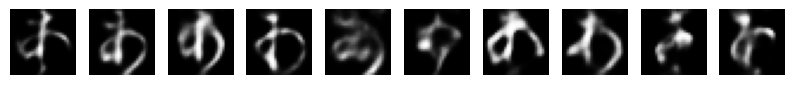

In [11]:
# Example: Generate new images of class 0 with style 'thin' (1)
generated_imgs = generate_images(model, 10, 0, 1)

# Plot the generated images
plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_imgs[i].view(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
